In [485]:
import numpy as np
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 27.1 ms


In [6]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 209 ms


In [7]:
ds.close()

time: 24.7 ms


In [344]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.2 s


In [489]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2019-03-01', '2019-07-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 7.33 s


In [490]:
#df_sklearn

time: 18.6 ms


In [491]:
#df_sklearn[df_sklearn['afgkode'] == 252].describe()

time: 18.8 ms


In [492]:
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug', 'Vårhvede'])]
crop_codes = df_sklearn['afgkode'].unique()
mapping_dict = {}
class_names = [] 

for i, crop_code in enumerate(crop_codes):
    mapping_dict[crop_code] = i
    crop_type = df_sklearn[df_sklearn['afgkode'] == crop_code].head(1)['afgroede'].values[0]
    class_names.append(crop_type)

df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped['afgkode'] = df_sklearn_remapped['afgkode'].map(mapping_dict)
print(f"Crop types: {class_names}")

Crop types: ['Kartofler, stivelses-', 'Kartofler, lægge- (egen opformering)', 'Kartofler, andre', 'Kartofler, spise-', 'Kartofler, lægge- (certificerede)', 'Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 'Vinterbyg', 'Vårhavre', 'Vinterhybridrug', 'Vårhvede', 'Grønkorn af vårbyg', 'Vårbyg, helsæd', 'Majs til modenhed', 'Skovdrift, alm.', 'Sukkerroer til fabrik', 'Juletræer og pyntegrønt på landbrugsjord', 'Permanent græs, normalt udbytte']
time: 52 ms


In [493]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,3:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int16(array[:,1])  # The column 'afgkode'

time: 350 ms


In [497]:
# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      38548
Test samples:       16521
Number of features: 75
time: 37 ms


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Training time: 52.261 s
Prediction time: 0.0058 s

Report:

Train accuracy: 0.7734
Test accuracy: 0.7661

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.69      0.96      0.80      1346
    Kartofler, lægge- (egen opformering)       0.08      0.00      0.01       204
                        Kartofler, andre       0.11      0.01      0.01       165
                       Kartofler, spise-       0.61      0.43      0.50       376
       Kartofler, lægge- (certificerede)       0.47      0.12      0.19       137
                                  Vårbyg       0.72      0.82      0.76      1156
                             Vinterhvede       0.88      0.93      0.91      1106
                                Silomajs       0.81      0.93      0.87      1461
                              Vinterraps       0.99      0.99      0.99      1104
                               Vinterbyg       0.97      0.96      0.96 

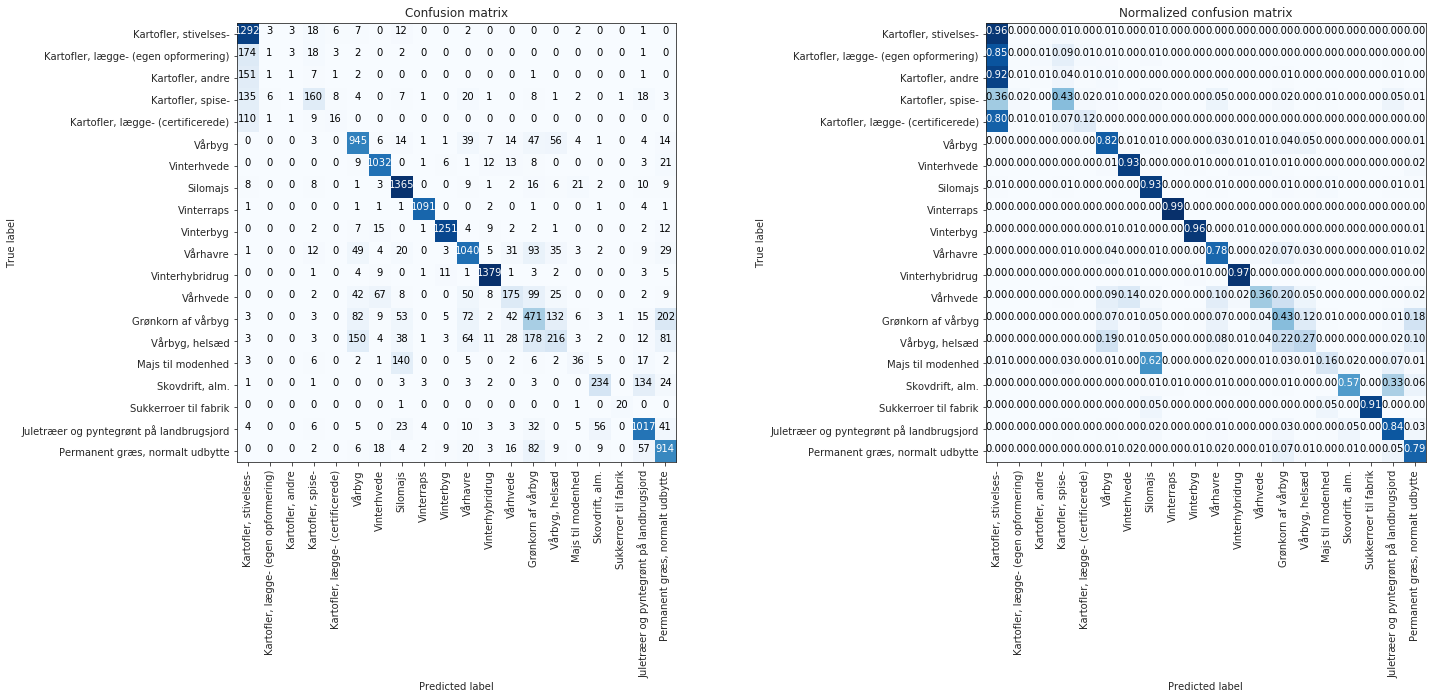

time: 55 s


In [500]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
clf = LogisticRegression(solver='newton-cg', max_iter=1000)

# Evaluate classifier without feature scaling
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

In [512]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25), max_iter=1000)  # See what happens when you change random state
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

time: 67.4 ms


In [507]:
# https://automl.github.io/auto-sklearn/master/installation.html#installing-auto-sklearn
!sudo apt-get update
!sudo apt-get install -yy build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194  100   194    0     0    310      0 --:--:-- --:--:-- --:--:--   310
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://gith

FileNotFoundError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.7/site-packages/scikit_learn-0.22.1.dist-info/METADATA'

time: 1min 8s


In [510]:
import autosklearn.classification

clf = autosklearn.classification.AutoSklearnClassifier()
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)

AttributeError: module 'sklearn' has no attribute 'metrics'

time: 43.3 ms


In [511]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

AttributeError: module 'sklearn' has no attribute 'metrics'

time: 45 ms
